<div align='center'><font size="4" color="grey">Fake news is a real problem</font><br><br>

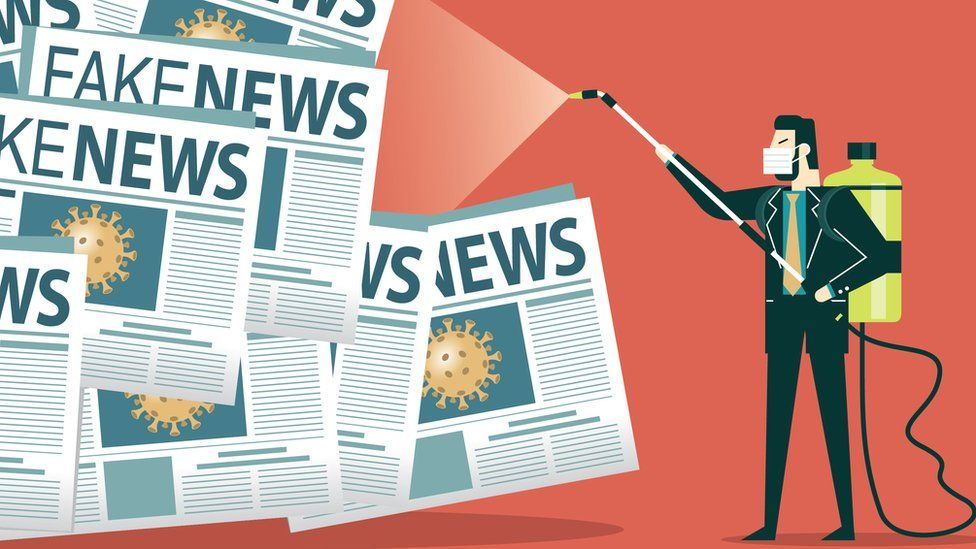

# Problem Statement
<p> We have 2 datasets with Real News data and Fake News data. Each dataset has around 22000 articles. As we merge both, we have around 45000 articles of real and fake. The aim is to build a model to correctly predict if a news is real or fake. 

# Table of Contents
1. [Objective](#objective)
2. [Import Packages](#import-packages)
3. [Read Data](#read-data)
    * [Create Target based on Real and Fake data](#create-target)
    * [Concat both real and fake data](#concat-data)
4. [Data Analysis](#data-analysis)
    * [Missing value Treatment](#treat-missing-value)
    * [Merge Title and Text data](#merge-title-text)
5. [Data Visualization](#data-visualization)
6. [Data Cleaning](#data-cleaning)
    * [Create text sequences and padding](#create-sequence-padding)
7. [Reduce Memory Usage (Free unused dataframe and objects)](#reduce_memory)
8. [Word Embeddings using GloVe vectors](#word-embeddings)
    * [Create embedding matrix](#embedding-matrix)
9. [Train with LSTM](#lstm_train)
    * [Evaluate LSTM Model](#evaluate-lstm)
10. [Train with GRU](#train_gru)
    * [Evaluate GRU Model](#evaluate-gru)

# Objective
<a id = "objective"></a>

This kernel is the continuation of my previous work with the same dataset, where I have used CountVectorizer and TFIDF Vectorizer with Classification models and OneHotVector with LSTM.<br>
In this kernel I will predict real and fake news using Glove Vector with LSTM and GRU models.

# Import Packages
<a id = "import-packages"></a>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History 

from wordcloud import WordCloud, STOPWORDS

# Read Data
<a id = "read-data"></a>


In [ ]:
real = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
real.head()

In [ ]:
fake = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
fake.head()

**Create Target based on Real and Fake data**
<a id="create-target"></a>


In [ ]:
real['Category'] = 1
fake['Category'] = 0

In [ ]:
print(real.shape)
real.head()

In [ ]:
print(fake.shape)
fake.head()

**Concat both real and fake data**
<a id = "concat-data"></a>


In [ ]:
dataset = pd.concat([real, fake]).reset_index(drop=True)

In [ ]:
print(dataset.shape)
dataset.head()

In [ ]:
import gc
del [[real,fake]]
gc.collect()

# Data Analysis
<a id = "data-analysis"></a>

**Missing value Treatment**
<a id = "treat-missing-value"></a>

In [ ]:
dataset.isnull().sum()

<p> There is no missing value in the dataset, so we we can work directly on title and text columns

**Merge Title and Text data**
<a id = "merge-title-text"></a>

In [ ]:
dataset['final_text'] = dataset['title'] + dataset['text']
dataset['final_text'].head()

# Data Visualization
<a id ="data-visualization"></a>

In [ ]:
dataset['Category'].value_counts()

In [ ]:
sns.countplot(dataset["Category"])

In [ ]:
dataset[['Category','subject','final_text']].groupby(['Category','subject']).count()

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x= "subject", hue = "Category", data=dataset)

# Data Cleaning
<a id = "data-cleaning"></a>

In this step we will clean the data that will be used for training. The cleaning will involve these steps-
1. Removing all the extra information like brackets, any kind of puctuations - commas, apostrophes, quotes, question marks, and more.
2. Remove all the numeric text, urls
3. Remove all the stop words like - just, and, or, but, if
4. Convert all the remaining text in the lower case, separated by space

In [ ]:
final_text_result = []
for text in dataset['final_text']:
    result = re.sub('[^a-zA-Z]', ' ', text)
    result = result.lower()
    result = result.split()
    result = [r for r in result if r not in set(stopwords.words('english'))]
    final_text_result.append(" ".join(result))

In [ ]:
print(len(final_text_result))

**Create text sequences and padding**
<a id="create-sequence-padding"></a>

In [ ]:
X_final = np.array(final_text_result)
y_final = dataset['Category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [ ]:
from tensorflow.keras.preprocessing import text
max_words = 10000
tokenizer = text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [ ]:
# Generate sequence of Tokens
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Pad the sequences
sent_length = 400
X_train_pad = sequence.pad_sequences(X_train_sequence, maxlen=sent_length)
X_test_pad = sequence.pad_sequences(X_test_sequence, maxlen=sent_length)

In [ ]:
word_index = tokenizer.word_index

# Reduce Memory Usage (Free unused dataframe and objects)
<a id="reduce_memory"></a>

Till this point we have consumed lots of memory and as there is limited memory for kernel, some unused dataframes and objects need to be free in order to train the dataset.<br>
Below is the Session Metrics of this kernel at this point and almost 92% of the total memory is used.<br>

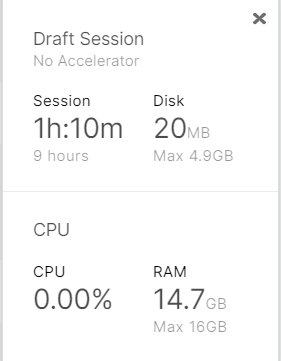

In [ ]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
dataset = reduce_mem_usage(dataset)
del final_text_result
del X_final
del y_final
del X_train
del X_test
del X_train_sequence
del X_test_sequence
gc.collect()

This is the Session Metrics after memory optimization.<br>

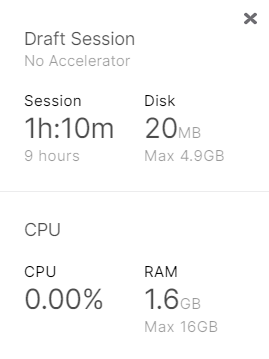

**And Memory consumption is reduced from 14.7 GB to 1.6 GB, i.e. almost 90% of the memory is free.**

# Word Embeddings using GloVe vectors
<a id  = "word-embeddings"></a>

GloVe, stands for "Global Vectors", is a model for distributed word representation. The model is an unsupervised learning algorithm for obtaining vector representations for words. This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity. <br><br>
GloVe is developed as an open-source project at Stanford. 
<br><br>As log-bilinear regression model for unsupervised learning of word representations, it combines the features of two model families, namely the global matrix factorization and local context window methods.<br>
GloVe captures both global statistics and local statistics of a corpus, in order to come up with word vectors. Turns out, it each type of statistic has their own advantage. For example, Word2vec which captures local statistics do very well in analogy tasks. However a method like LSA which uses only global statistics does not do that well in analogy tasks.
<br><br>
Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 


In [ ]:
GLOVE_EMBEDDINGS_FILE = "../input/glovetwitter27b100d/glove.twitter.27B.100d.model"

In [ ]:
%%time
embedding_vectors = {}
with open(GLOVE_EMBEDDINGS_FILE,'r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print("Size of vocabulary in GloVe: ", len(embedding_vectors))  

**Create embedding matrix**
<a id = "embedding-matrix"></a>

In this step I am creating and initializing the embedding_matrix with zeros and use this in the LSTM model weight.

In [ ]:
emb_dim = 100
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

# Train with LSTM
<a id = "lstm_train"></a>

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
# lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

In [ ]:
%%time
seq_model1 = lstm_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

**Evaluate LSTM Model**
<a id = "evaluate-lstm"></a>

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = seq_model1.history['accuracy']
train_loss = seq_model1.history['loss']
val_acc = seq_model1.history['val_accuracy']
val_loss = seq_model1.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
train_lstm_results = lstm_model.evaluate(X_train_pad, y_train, verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(X_test_pad, y_test, verbose=0, batch_size=256)
print("Train accuracy: {}".format(train_lstm_results[1]*100))
print("Test accuracy: {}".format(test_lstm_results[1]*100))

In [ ]:
y_pred = lstm_model.predict_classes(X_test_pad)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

# Train with GRU
<a id = "train_gru"></a>

In [ ]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

In [ ]:
%%time
seq_model2 = gru_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

**Evaluate GRU Model**
<a id = "evaluate-gru"></a>

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = seq_model2.history['accuracy']
train_loss = seq_model2.history['loss']
val_acc = seq_model2.history['val_accuracy']
val_loss = seq_model2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
train_gru_results = gru_model.evaluate(X_train_pad, y_train, verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(X_test_pad, y_test, verbose=0, batch_size=256)
print("Train accuracy: {}".format(train_gru_results[1]*100))
print("Test accuracy: {}".format(test_gru_results[1]*100))

In [ ]:
y_pred = gru_model.predict_classes(X_test_pad)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

## So here we see Glove Vectors with GRU are giving the best results with an accuracy of 99.8%.

**If you like the kernel please upvote.
If you have any questions/feedback feel free to comment and I will be happy to answer.
**